# Data Understanding

In [1]:
import jieba
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jieba.posseg as pseg
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from wordcloud import WordCloud

In [2]:
df = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/train.json')
df1 = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/test.json')
df2 = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/dev.json')

In [3]:
dfs = [df, df1, df2]

# Concatenate DataFrames vertically (along rows)
combined_df = pd.concat(dfs, ignore_index=True)

# Print the combined DataFrame
combined_df.head()

,claim,title,source,claimWeb,category,url,publish_date,editor,label,claimId,domain,verification method,evidence,gold evidence,verification社会ethod
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,中国驻英国使馆网站,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2021-03/25/c_12110818...,2021-03-25,谢博隆,0,5,政治,专家咨询,{'0': {'text': '2021年3月22日，驻英国使馆杨晓光临时代办先后接受英国天...,{'0': {'text': '新疆棉花生产早已经实现高度机械化，即使在忙碌的采摘季节，也不...,NaN
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,中国互联网联合辟谣平台,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-10/29/c_12108633...,2020-10-29,殷荧,0,27,社会,证据搜集,{'0': {'text': '由内容质量、互动评论、分享传播等多维度分值决定，勋章级别越高...,"{'0': {'text': '答：按政策规定，失业保险金和失业补助金不可以同时领取。'},...",NaN
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,新华社,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-10/29/c_12108629...,2020-10-29,殷荧,0,32,社会,专家咨询,{'0': {'text': '新华社北京10月28日电（记者姜琳）今年社保费减免力度空前，...,{'0': {'text': '人力资源和社会保障部28日回应，保发放提前进行了准备和安排，...,NaN
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,科技日报,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-08/20/c_12107612...,2020-08-20,冯栋,0,38,社会,证据搜集,{'0': {'text': '原标题：为打赢污染防治攻坚战，《城镇生活污水处理设施补短板强...,{'0': {'text': '原标题：为打赢污染防治攻坚战，《城镇生活污水处理设施补短板强...,NaN
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,科技日报,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-04/20/c_12105781...,2020-04-20,殷荧,0,63,社会,专家咨询， 数值推理,{'0': {'text': '原标题：截至3月底，猪肉批发价格已连续7周下跌来源：新京报全...,{'0': {'text': '陈萍提出，分品种看，猪肉价格持续小幅下跌，截至3月底全国猪肉...,NaN


In [4]:
combined_df.to_excel('C:/Users/User/OneDrive - Universiti Malaya/CHEF/Combined_Data.xlsx')

In [5]:
label_counts = combined_df['label'].value_counts()

print(label_counts)

label
1    5015
0    3543
2    1442
Name: count, dtype: int64


In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                10000 non-null  object
 1   title                10000 non-null  object
 2   source               10000 non-null  object
 3   claimWeb             10000 non-null  object
 4   category             10000 non-null  object
 5   url                  10000 non-null  object
 6   publish_date         10000 non-null  object
 7   editor               10000 non-null  object
 8   label                10000 non-null  int64 
 9   claimId              10000 non-null  int64 
 10  domain               10000 non-null  object
 11  verification method  9999 non-null   object
 12  evidence             10000 non-null  object
 13  gold evidence        10000 non-null  object
 14  verification社会ethod  1 non-null      object
dtypes: int64(2), object(13)
memory usage: 1.1+ MB


In [7]:
combined_df = combined_df.drop(columns=['verification社会ethod'])

combined_df = combined_df[combined_df['label'] != 2]

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8558 entries, 0 to 9666
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                8558 non-null   object
 1   title                8558 non-null   object
 2   source               8558 non-null   object
 3   claimWeb             8558 non-null   object
 4   category             8558 non-null   object
 5   url                  8558 non-null   object
 6   publish_date         8558 non-null   object
 7   editor               8558 non-null   object
 8   label                8558 non-null   int64 
 9   claimId              8558 non-null   int64 
 10  domain               8558 non-null   object
 11  verification method  8557 non-null   object
 12  evidence             8558 non-null   object
 13  gold evidence        8558 non-null   object
dtypes: int64(2), object(12)
memory usage: 1002.9+ KB


In [9]:
combined_df.isnull().any()

claim                  False
title                  False
source                 False
claimWeb               False
category               False
url                    False
publish_date           False
editor                 False
label                  False
claimId                False
domain                 False
verification method     True
evidence               False
gold evidence          False
dtype: bool

In [10]:
combined_df['verification method'].fillna("Not applicable", inplace=True)

In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8558 entries, 0 to 9666
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                8558 non-null   object
 1   title                8558 non-null   object
 2   source               8558 non-null   object
 3   claimWeb             8558 non-null   object
 4   category             8558 non-null   object
 5   url                  8558 non-null   object
 6   publish_date         8558 non-null   object
 7   editor               8558 non-null   object
 8   label                8558 non-null   int64 
 9   claimId              8558 non-null   int64 
 10  domain               8558 non-null   object
 11  verification method  8558 non-null   object
 12  evidence             8558 non-null   object
 13  gold evidence        8558 non-null   object
dtypes: int64(2), object(12)
memory usage: 1002.9+ KB


In [12]:
combined_df['label'].value_counts()

label
1    5015
0    3543
Name: count, dtype: int64

# Data Preprocessing

Remove IP addresses, stop words and punctuation
Tokenization

In [13]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [14]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res

In [15]:
jieba_df = combined_df[["claim", "title", "label"]]

jieba_df.head()

,claim,title,label
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,0
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,0
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,0
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,0
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,0


In [16]:
jieba_df.isna().any()

claim    False
title    False
label    False
dtype: bool

In [17]:
jieba_df["tokenized_claim"] = process(jieba_df.loc[:,"claim"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.726 seconds.
Prefix dict has been built successfully.
C:\Users\User\AppData\Local\Temp\ipykernel_16144\1546768494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df["tokenized_claim"] = process(jieba_df.loc[:,"claim"])


In [18]:
jieba_df["tokenized_title"] = process(jieba_df.loc[:,"title"])

C:\Users\User\AppData\Local\Temp\ipykernel_16144\4142103444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df["tokenized_title"] = process(jieba_df.loc[:,"title"])


In [19]:
jieba_df.head()

,claim,title,label,tokenized_claim,tokenized_title
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,0,新疆 棉花 生产 已 实现 高度 机械化 不 需要 强迫 劳动,中 使馆 驳斥 涉疆 谣言 新疆 棉花 生产 已 实现 高度 机械化 哪里 还 需要 强迫 劳动
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,0,失业 保险金 不 等于 失业 补助金,关于 失业 保险金 你 可能 有 太 多 误区
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,0,退休职工 养老金 能 按时 足额 发放,退休职工 养老金 能否 按时 足额 发放 人社部 回应 了
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,0,中国 污水处理 能力 限制 城市 发展,污水处理 能力 限制 城市 发展 补齐 设施 短板
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,0,截至 2020 年 3 月底 猪肉 价格 持续 小幅 下跌,这场 发布会 回应 舌尖 上 的 问题


In [20]:
jieba_df.isna().any()

claim              False
title              False
label              False
tokenized_claim    False
tokenized_title    False
dtype: bool

In [21]:
jieba_df.loc[:,"content"] = jieba_df.tokenized_claim + jieba_df.tokenized_title

jieba_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_16144\1408174343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df.loc[:,"content"] = jieba_df.tokenized_claim + jieba_df.tokenized_title


,claim,title,label,tokenized_claim,tokenized_title,content
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,0,新疆 棉花 生产 已 实现 高度 机械化 不 需要 强迫 劳动,中 使馆 驳斥 涉疆 谣言 新疆 棉花 生产 已 实现 高度 机械化 哪里 还 需要 强迫 劳动,新疆 棉花 生产 已 实现 高度 机械化 不 需要 强迫 劳动中 使馆 驳斥 涉疆 谣言 新...
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,0,失业 保险金 不 等于 失业 补助金,关于 失业 保险金 你 可能 有 太 多 误区,失业 保险金 不 等于 失业 补助金关于 失业 保险金 你 可能 有 太 多 误区
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,0,退休职工 养老金 能 按时 足额 发放,退休职工 养老金 能否 按时 足额 发放 人社部 回应 了,退休职工 养老金 能 按时 足额 发放退休职工 养老金 能否 按时 足额 发放 人社部 回应 了
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,0,中国 污水处理 能力 限制 城市 发展,污水处理 能力 限制 城市 发展 补齐 设施 短板,中国 污水处理 能力 限制 城市 发展污水处理 能力 限制 城市 发展 补齐 设施 短板
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,0,截至 2020 年 3 月底 猪肉 价格 持续 小幅 下跌,这场 发布会 回应 舌尖 上 的 问题,截至 2020 年 3 月底 猪肉 价格 持续 小幅 下跌这场 发布会 回应 舌尖 上 的 问题


# Visualization

In [22]:
def map_labels(label):
    if label == 0:
        return 'Fake'
    elif label == 1:
        return 'True'
    else:
        return 'unknown'  # Handle other cases if needed

# Apply the function to create a new column
EDA_df=combined_df.copy()
EDA_df['label_meaning'] = combined_df['label'].apply(map_labels)

C:\Users\User\AppData\Local\Temp\ipykernel_16144\551137674.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=custom_palette)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


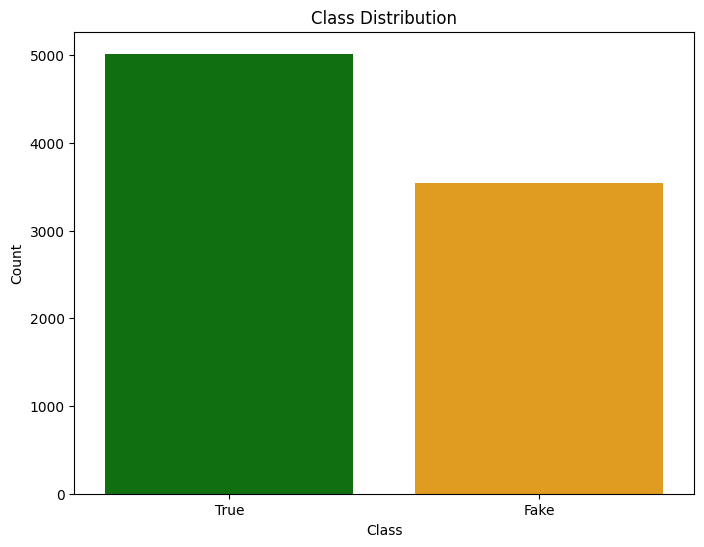

In [23]:
class_counts = EDA_df['label_meaning'].value_counts()

# Create a custom color palette
custom_palette = ['green','orange']

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=custom_palette)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend().remove()
plt.show()

In [24]:
EDA_df['publish_date'] = df['publish_date'].str.replace("/", "-")

EDA_df['publish_date'] = pd.to_datetime(EDA_df["publish_date"], errors = "coerce")

# Extract year and month to a new column
EDA_df['year_month'] = EDA_df['publish_date'].dt.to_period('M')

# Change the data type from Period to string
EDA_df['year_month'] = EDA_df['year_month'].astype(str)


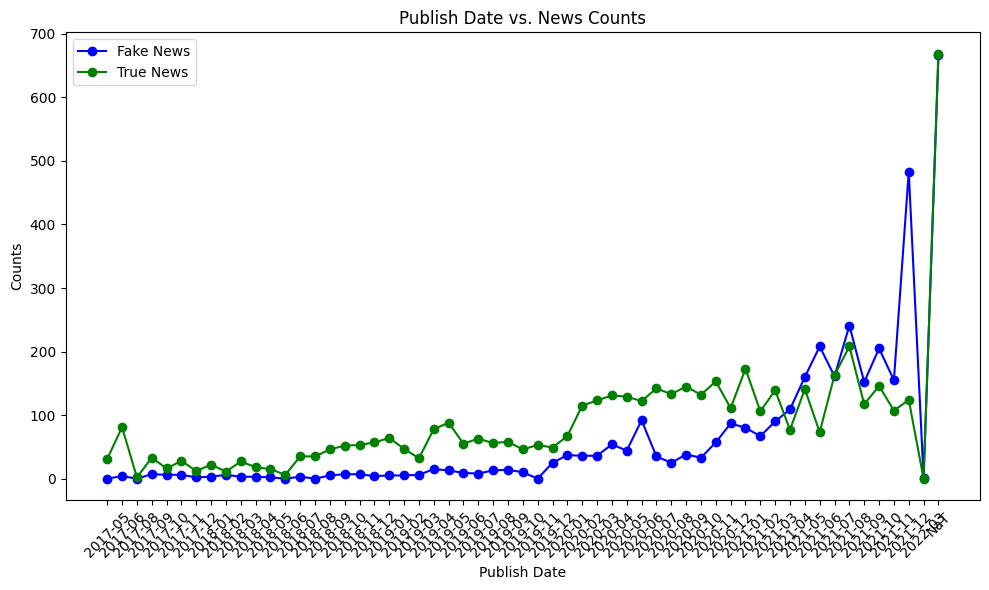

In [25]:
news_counts = EDA_df.groupby(['year_month', 'label_meaning']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the line graphs for fake news and true news counts
plt.plot(news_counts.index, news_counts['Fake'], marker='o', linestyle='-', color='b', label='Fake News')
plt.plot(news_counts.index, news_counts['True'], marker='o', linestyle='-', color='g', label='True News')

# Customize the plot
plt.title('Publish Date vs. News Counts')
plt.xlabel('Publish Date')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

plt.tight_layout()  # Adjust layout for better appearance
plt.show()  # Display the plot

In [26]:
# Find the chinese font in system 
from matplotlib import font_manager

# Access the list of available fonts
fonts = font_manager.findSystemFonts()

# print or search for the specific font
for font in fonts:
    print(font)
    
    
# To know the font name, can go to control panel --> Search "font" --> "View installed fonts"

C:\Windows\Fonts\comic.ttf
C:\Windows\Fonts\GOTHICB.TTF
C:\Windows\Fonts\saswalb.ttf
C:\Windows\Fonts\segoescb.ttf
C:\Windows\Fonts\LBRITEI.TTF
C:\Windows\Fonts\taileb.ttf
C:\Windows\Fonts\avncyrr.ttf
C:\Windows\Fonts\comici.ttf
C:\Windows\Fonts\TCBI____.TTF
C:\Windows\Fonts\GARA.TTF
C:\Windows\Fonts\BRLNSB.TTF
C:\Windows\Fonts\YuGothM.ttc
C:\Windows\Fonts\MTCORSVA.TTF
C:\Windows\Fonts\PERTILI.TTF
C:\Windows\Fonts\sasgasb.ttf
C:\Windows\Fonts\seguibli.ttf
C:\Windows\Fonts\GARAIT.TTF
C:\Windows\Fonts\saswthi.ttf
C:\Windows\Fonts\segoeui.ttf
C:\Windows\Fonts\PLAYBILL.TTF
C:\Windows\Fonts\FRAHVIT.TTF
C:\Windows\Fonts\BELLI.TTF
C:\Windows\Fonts\sasgtsr.ttf
C:\Windows\Fonts\segoeprb.ttf
C:\Windows\Fonts\consolai.ttf
C:\Windows\Fonts\arialbi.ttf
C:\Windows\Fonts\sasmonob.ttf
C:\Windows\Fonts\phagspab.ttf
C:\Windows\Fonts\RAVIE.TTF
C:\Windows\Fonts\YuGothL.ttc
C:\Windows\Fonts\BOD_R.TTF
C:\Windows\Fonts\Candarai.ttf
C:\Windows\Fonts\FRAMDCN.TTF
C:\Windows\Fonts\FRABK.TTF
C:\Windows\Fonts\sasg

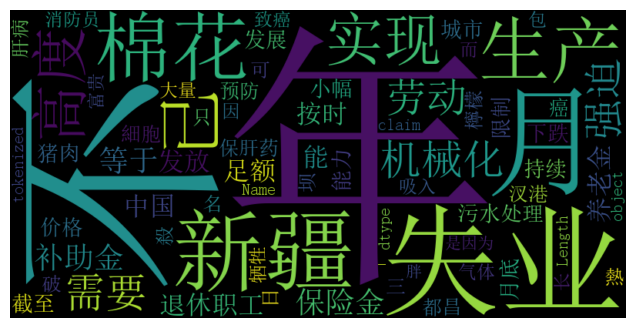

In [27]:
words = jieba.cut(str(jieba_df["tokenized_claim"]))
word_list = " ".join(words)
wordcloud = WordCloud(width=800, height=400, background_color='black', font_path="C:\Windows\Fonts\simsun.ttc").generate(word_list)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature Extraction

## BoW

In [28]:
# BoW
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
bow_matrix = count_vectorizer.fit_transform(jieba_df["content"].values)

In [29]:
targets = jieba_df["label"]

In [30]:
print(f"target shape: {targets.shape}")
print(f"X shape: {bow_matrix.shape}")

target shape: (8558,)
X shape: (8558, 113386)


In [31]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_matrix, targets, test_size=0.2, random_state=49)

In [32]:
print(f"The shape of X_train_bow is: {X_train_bow.shape[0]}")
print(f"The shape of X_test_bow is: {X_test_bow.shape[0]}")

The shape of X_train_bow is: 6846
The shape of X_test_bow is: 1712


## TFIDF

In [33]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(jieba_df["content"].values)

In [34]:
targets = jieba_df["label"]

In [35]:
print(f"target shape: {targets.shape}")
print(f"X shape: {tfidf_matrix.shape}")

target shape: (8558,)
X shape: (8558, 29631)


In [36]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, targets, test_size=0.2, random_state=49)

In [37]:
print(f"The shape of X_train_tfidf is: {X_train_tfidf.shape[0]}")
print(f"The shape of X_test_tfidf is: {X_test_tfidf.shape[0]}")

The shape of X_train_tfidf is: 6846
The shape of X_test_tfidf is: 1712


## BoW-TFIDF

TF-IDF, GloVe, Word2Vec, BERT, FastText

In [38]:
# BoW
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(jieba_df["content"].values)

# TF-IDF
transformer = TfidfTransformer(smooth_idf=False)
bowtfidf = transformer.fit_transform(counts)

In [39]:
targets = jieba_df["label"]

In [40]:
print(f"target shape: {targets.shape}")
print(f"X shape: {bowtfidf.shape}")

target shape: (8558,)
X shape: (8558, 113386)


In [41]:
X_train_bowtfidf, X_test_bowtfidf, y_train_bowtfidf, y_test_bowtfidf = train_test_split(bowtfidf, targets, test_size=0.2, random_state=49)

In [42]:
print(f"The shape of X_train_bowtfidf is: {X_train_bowtfidf.shape[0]}")
print(f"The shape of X_test_bowtfidf is: {X_test_bowtfidf.shape[0]}")

The shape of X_train_bowtfidf is: 6846
The shape of X_test_bowtfidf is: 1712


## Word2Vec

In [43]:
sentences = jieba_df["content"].tolist()

In [44]:
from gensim.models import Word2Vec

# Assuming "sentences" is a list of tokenized sentences
model_word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)

C:\Users\User\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [45]:
similar_words = model_word2vec.wv.most_similar("新", topn=5)
for word, score in similar_words:
    print(word, score)

佳 0.5168555378913879
狀 0.48309841752052307
脉 0.46699056029319763
涉 0.4406314790248871
案 0.43783921003341675


In [46]:
def document_vector(tokens, model):
    # Filter out words that are not in the model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]
    
    if len(valid_tokens) == 0:
        return None  # Return None for documents with no valid tokens
    
    # Calculate the average vector of valid tokens
    return sum(model.wv[valid_tokens]) / len(valid_tokens)

# Apply the document_vector function to create a new 'doc_vector' column
jieba_df['doc_vector'] = jieba_df["content"].apply(lambda tokens: document_vector(tokens, model_word2vec))

# Split the data into training and testing sets
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(jieba_df['doc_vector'].tolist(), jieba_df['label'].tolist(), test_size=0.2, random_state=42)

C:\Users\User\AppData\Local\Temp\ipykernel_16144\1286260484.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df['doc_vector'] = jieba_df["content"].apply(lambda tokens: document_vector(tokens, model_word2vec))


In [47]:
print(f"The number of samples in X_train_word2vec is: {len(X_train_word2vec)}")
print(f"The number of samples in X_test_word2vec is: {len(X_test_word2vec)}")

The number of samples in X_train_word2vec is: 6846
The number of samples in X_test_word2vec is: 1712


# Modeling

https://www.kaggle.com/code/ahmedtronic/fake-news-classification

In [48]:
# Create empty list for performance comparison
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Create a function to append the result to the list
def performance_comparison(y_test, model):
    a = accuracy_score(y_test, model)
    p =precision_score(y_test, model)
    r =recall_score(y_test, model)
    f =f1_score(y_test, model)
    
    accuracies.append(round(a, 4) * 100)
    precisions.append(round(p, 4) * 100)
    recalls.append(round(r, 4) * 100)
    f1_scores.append(round(f, 4) * 100)

# Create a function for model prediction
def bestModel(model, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    
    # Get the best Parameter
    best_params = grid_search.best_params_
    
    # Mean cross-validated score
    best_cv_score = grid_search.best_score_
    
    # Get the best model
    best_model = grid_search.best_estimator_

    # Get the best model score
    best_model_score = best_model.score(X_test, y_test)
    
    # Classification report
    predictor = best_model.predict(X_test)
    classification = classification_report(y_test, predictor, digits=4)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    print("Best testing score:", best_model_score)

    print("")
    print("-"*20)
    print("")

    print(classification)

    # Confusion Matrix 
    disp = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
    
    # Input the result to the list
    performance_comparison(y_test, predictor)

## Support Vector Machine (SVM) with BoW

Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.8742332034145015
Best testing score: 0.8785046728971962

--------------------

              precision    recall  f1-score   support

           0     0.8638    0.8369    0.8501       705
           1     0.8882    0.9076    0.8978      1007

    accuracy                         0.8785      1712
   macro avg     0.8760    0.8723    0.8740      1712
weighted avg     0.8782    0.8785    0.8782      1712



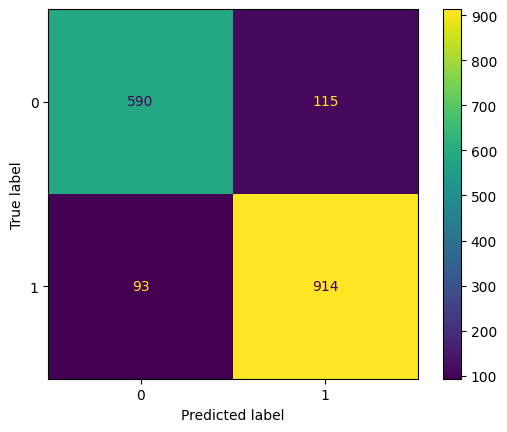

In [49]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
}

bestModel(svm, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

## Support Vector Machine (SVM) with TFIDF

Best parameters: {'C': 10, 'gamma': 1}
Best cross-validation score: 0.88168123143858
Best testing score: 0.884929906542056

--------------------

              precision    recall  f1-score   support

           0     0.8994    0.8113    0.8531       705
           1     0.8764    0.9364    0.9054      1007

    accuracy                         0.8849      1712
   macro avg     0.8879    0.8739    0.8793      1712
weighted avg     0.8859    0.8849    0.8839      1712



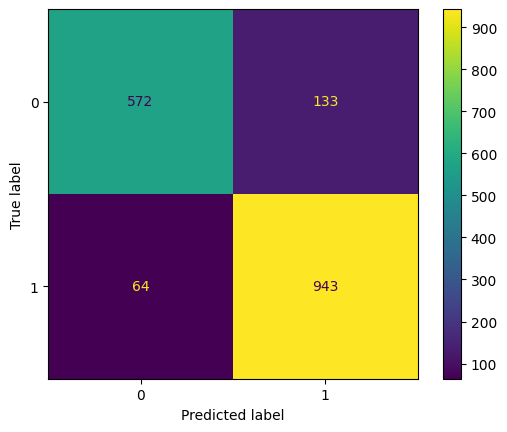

In [50]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
}

bestModel(svm, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

## Support Vector Machine (SVM) with BoW-TFIDF

In [51]:
# smote = SMOTE(sampling_strategy="auto", random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# unique, counts = np.unique(y_resampled, return_counts=True)
# class_distribution = dict(zip(unique, counts))
# print(class_distribution)

In [52]:
# SVM_model_smote = SVC(kernel="rbf", C=10, gamma=0.1)
# SVM_model_smote.fit(X_resampled, y_resampled)

# y_prediction = SVM_model_smote.predict(X_test)
# CR = classification_report(y_test, y_prediction, digits=4)
# print(CR)
# print(SVM_model_smote.score(X_test, y_test))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.8843104615761945
Best testing score: 0.8913551401869159

--------------------

              precision    recall  f1-score   support

           0     0.8986    0.8298    0.8628       705
           1     0.8869    0.9345    0.9101      1007

    accuracy                         0.8914      1712
   macro avg     0.8928    0.8821    0.8864      1712
weighted avg     0.8917    0.8914    0.8906      1712



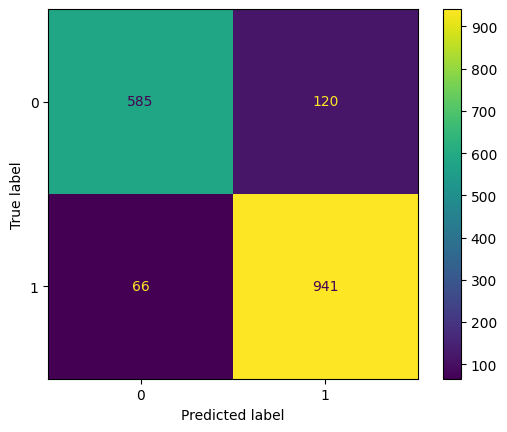

In [53]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
}

bestModel(svm, X_train_bowtfidf, y_train_bowtfidf, X_test_bowtfidf, y_test_bowtfidf)

## Support Vector Machine (SVM) with Word2Vec

Best parameters: {'C': 1, 'gamma': 1}
Best cross-validation score: 0.8507163308504795
Best testing score: 0.8545560747663551

--------------------

              precision    recall  f1-score   support

           0     0.8576    0.7701    0.8115       696
           1     0.8528    0.9124    0.8816      1016

    accuracy                         0.8546      1712
   macro avg     0.8552    0.8413    0.8466      1712
weighted avg     0.8548    0.8546    0.8531      1712



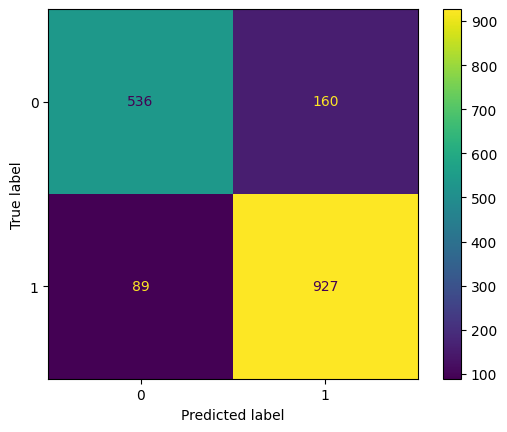

In [54]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
}

bestModel(svm, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec)

## K-Nearest Neighbours (KNN) with BoW

Best parameters: {'metric': 'euclidean', 'n_neighbors': 1}
Best cross-validation score: 0.6075094506619463
Best testing score: 0.6115654205607477

--------------------

              precision    recall  f1-score   support

           0     0.5154    0.9489    0.6680       705
           1     0.9130    0.3754    0.5320      1007

    accuracy                         0.6116      1712
   macro avg     0.7142    0.6622    0.6000      1712
weighted avg     0.7493    0.6116    0.5880      1712



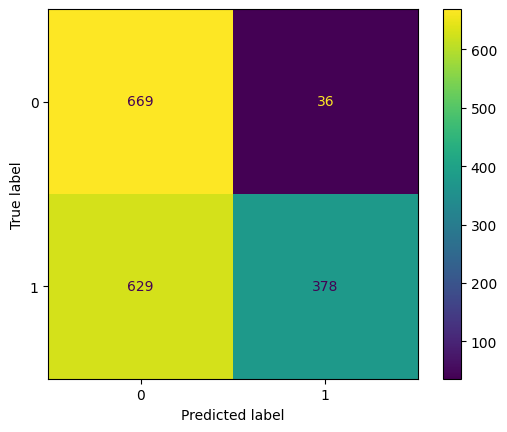

In [55]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan']
}

bestModel(knn, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

## K-Nearest Neighbours (KNN) with TFIDF

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}
Best cross-validation score: 0.8333310584208198
Best testing score: 0.8440420560747663

--------------------

              precision    recall  f1-score   support

           0     0.8269    0.7858    0.8058       705
           1     0.8551    0.8848    0.8697      1007

    accuracy                         0.8440      1712
   macro avg     0.8410    0.8353    0.8378      1712
weighted avg     0.8435    0.8440    0.8434      1712



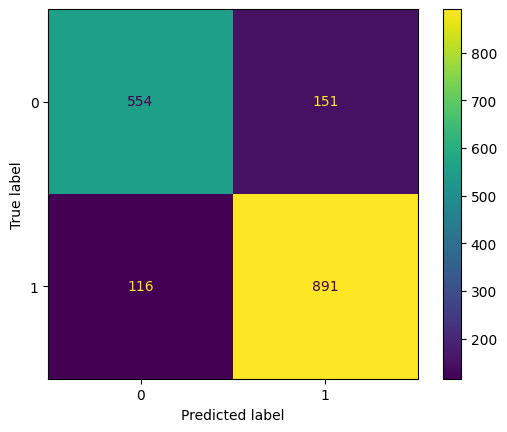

In [56]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan']
}

bestModel(knn, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

## K-Nearest Neighbours (KNN) with BoW-TFIDF

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}
Best cross-validation score: 0.8380065368189259
Best testing score: 0.8487149532710281

--------------------

              precision    recall  f1-score   support

           0     0.8369    0.7858    0.8105       705
           1     0.8562    0.8928    0.8741      1007

    accuracy                         0.8487      1712
   macro avg     0.8465    0.8393    0.8423      1712
weighted avg     0.8482    0.8487    0.8479      1712



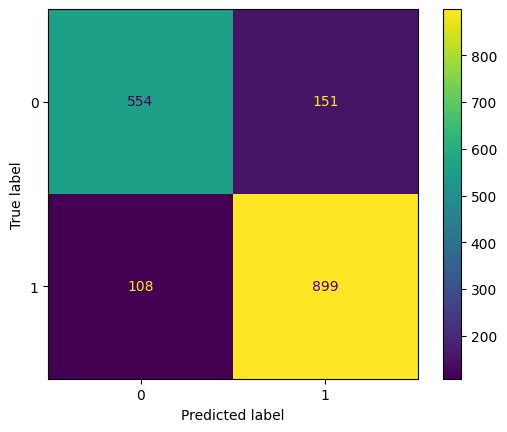

In [57]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan']
}

bestModel(knn, X_train_bowtfidf, y_train_bowtfidf, X_test_bowtfidf, y_test_bowtfidf)

## K-Nearest Neighbours (KNN) with Word2Vec

Best parameters: {'metric': 'manhattan', 'n_neighbors': 13}
Best cross-validation score: 0.8321653079396224
Best testing score: 0.8235981308411215

--------------------

              precision    recall  f1-score   support

           0     0.7806    0.7874    0.7840       696
           1     0.8535    0.8484    0.8509      1016

    accuracy                         0.8236      1712
   macro avg     0.8170    0.8179    0.8175      1712
weighted avg     0.8239    0.8236    0.8237      1712



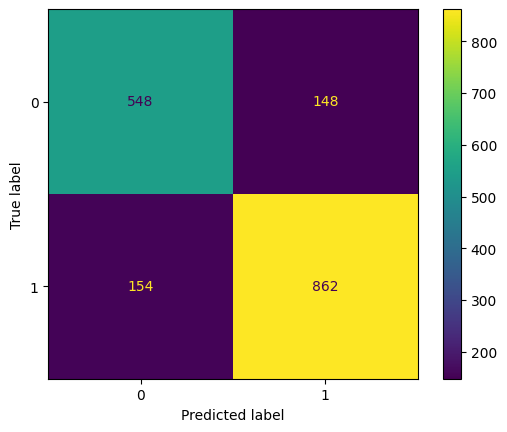

In [58]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan']
}

bestModel(knn, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec)

## Random Forest (RF) with BoW

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.8458947604143894
Best testing score: 0.8498831775700935

--------------------

              precision    recall  f1-score   support

           0     0.9029    0.7121    0.7962       705
           1     0.8244    0.9464    0.8812      1007

    accuracy                         0.8499      1712
   macro avg     0.8636    0.8292    0.8387      1712
weighted avg     0.8567    0.8499    0.8462      1712



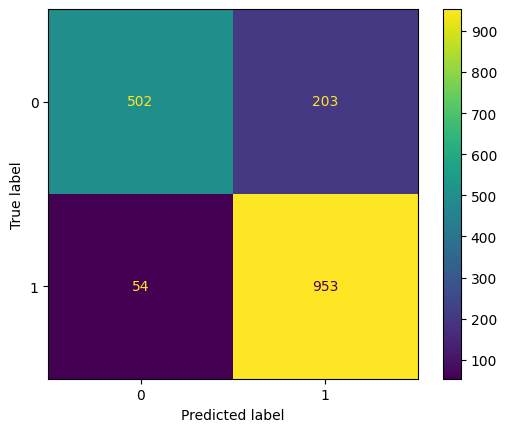

In [59]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

bestModel(rf, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

## Random Forest (RF) with TFIDF

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.8577265093067027
Best testing score: 0.8603971962616822

--------------------

              precision    recall  f1-score   support

           0     0.8923    0.7518    0.8160       705
           1     0.8435    0.9364    0.8875      1007

    accuracy                         0.8604      1712
   macro avg     0.8679    0.8441    0.8518      1712
weighted avg     0.8636    0.8604    0.8581      1712



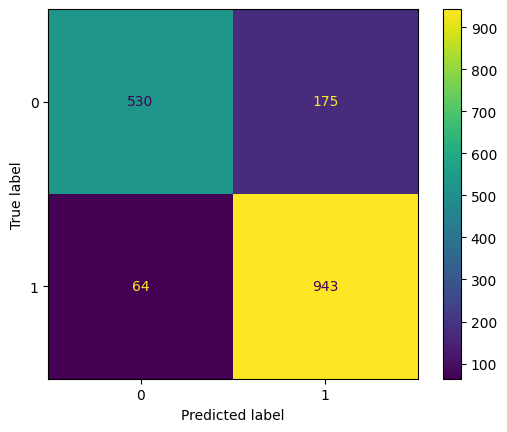

In [60]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

bestModel(rf, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

## Random Forest (RF) with BoW-TFIDF

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8496927268558754
Best testing score: 0.8533878504672897

--------------------

              precision    recall  f1-score   support

           0     0.9173    0.7078    0.7990       705
           1     0.8236    0.9553    0.8846      1007

    accuracy                         0.8534      1712
   macro avg     0.8705    0.8316    0.8418      1712
weighted avg     0.8622    0.8534    0.8494      1712



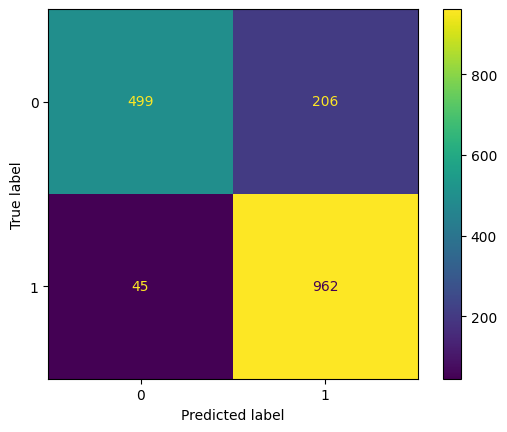

In [61]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

bestModel(rf, X_train_bowtfidf, y_train_bowtfidf, X_test_bowtfidf, y_test_bowtfidf)

## Random Forest (RF) with Word2Vec

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8393226447990703
Best testing score: 0.8311915887850467

--------------------

              precision    recall  f1-score   support

           0     0.8235    0.7443    0.7819       696
           1     0.8356    0.8907    0.8623      1016

    accuracy                         0.8312      1712
   macro avg     0.8296    0.8175    0.8221      1712
weighted avg     0.8307    0.8312    0.8296      1712



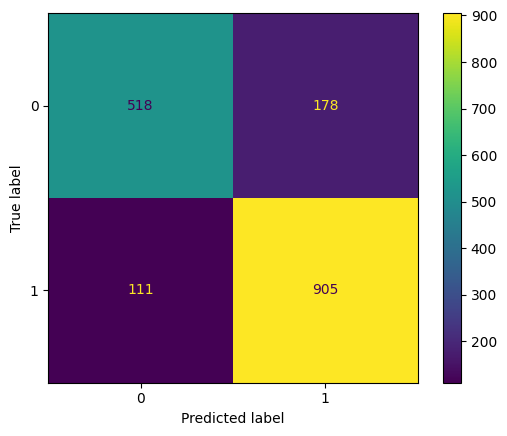

In [62]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

bestModel(rf, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec)

## Naive Bayes (NB) with BoW

Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.8489608803911428
Best testing score: 0.8504672897196262

--------------------

              precision    recall  f1-score   support

           0     0.7867    0.8738    0.8280       705
           1     0.9042    0.8342    0.8678      1007

    accuracy                         0.8505      1712
   macro avg     0.8455    0.8540    0.8479      1712
weighted avg     0.8558    0.8505    0.8514      1712



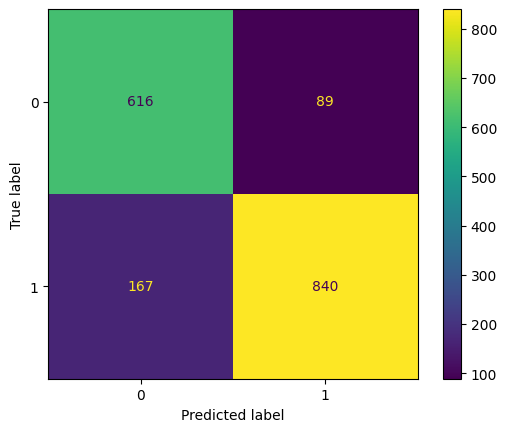

In [63]:
gnb = GaussianNB()

X_train_bow_dense = X_train_bow.toarray()
X_test_bow_dense = X_test_bow.toarray()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

bestModel(gnb, X_train_bow_dense, y_train_bow, X_test_bow_dense, y_test_bow)

## Naive Bayes (NB) with TFIDF

Best parameters: {'var_smoothing': 1e-05}
Best cross-validation score: 0.8052853326792959
Best testing score: 0.8008177570093458

--------------------

              precision    recall  f1-score   support

           0     0.7209    0.8426    0.7770       705
           1     0.8750    0.7716    0.8201      1007

    accuracy                         0.8008      1712
   macro avg     0.7979    0.8071    0.7985      1712
weighted avg     0.8115    0.8008    0.8023      1712



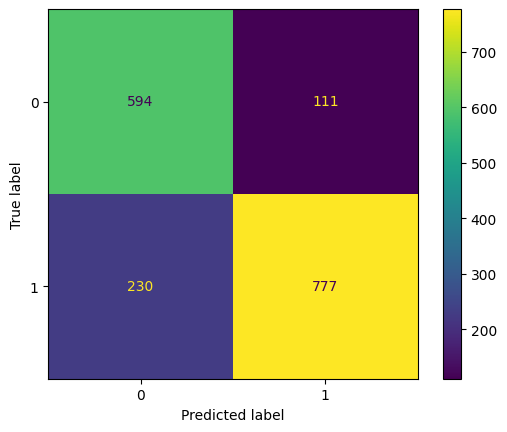

In [64]:
gnb = GaussianNB()

X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

bestModel(gnb, X_train_tfidf_dense, y_train_tfidf, X_test_tfidf_dense, y_test_tfidf)

## Naive Bayes (NB) with BoW-TFIDF

Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.8464769958358437
Best testing score: 0.8440420560747663

--------------------

              precision    recall  f1-score   support

           0     0.7859    0.8539    0.8185       705
           1     0.8911    0.8371    0.8633      1007

    accuracy                         0.8440      1712
   macro avg     0.8385    0.8455    0.8409      1712
weighted avg     0.8478    0.8440    0.8448      1712



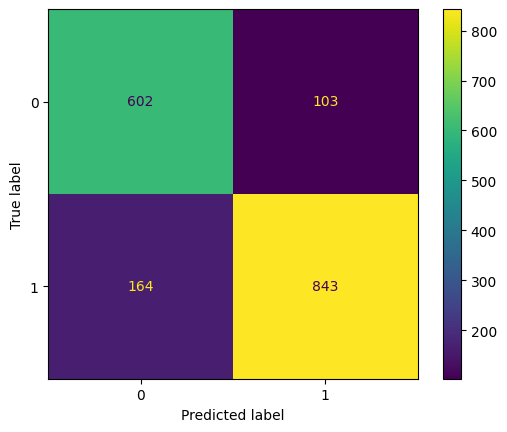

In [65]:
gnb = GaussianNB()

X_train_bowtfidf_dense = X_train_bowtfidf.toarray()
X_test_bowtfidf_dense = X_test_bowtfidf.toarray()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

bestModel(gnb, X_train_bowtfidf_dense, y_train_tfidf, X_test_bowtfidf_dense, y_test_tfidf)

## Naive Bayes (NB) with Word2Vec

Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.7268478776665795
Best testing score: 0.7067757009345794

--------------------

              precision    recall  f1-score   support

           0     0.6240    0.7011    0.6604       696
           1     0.7763    0.7106    0.7420      1016

    accuracy                         0.7068      1712
   macro avg     0.7002    0.7059    0.7012      1712
weighted avg     0.7144    0.7068    0.7088      1712



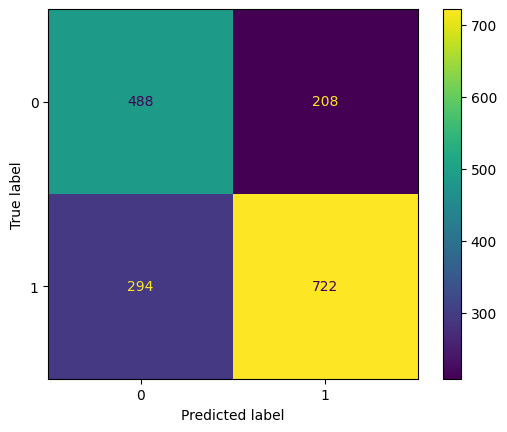

In [66]:
gnb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

bestModel(gnb, X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec)

# Evaluation

In [67]:
models = ["SVM with BoW", "SVM with TFIDF", "SVM with BoW-TFIDF", "SVM with Word2Vec", "KNN with BoW", "KNN with TFIDF",
          "KNN with BoW-TFIDF", "KNN with Word2Vec", "RF with BoW", "RF with TFIDF","RF with BoW-TFIDF", "RF with Word2Vec", 
          "NB with BoW", "NB with TFIDF","NB with BoW-TFIDF", "NB with Word2Vec"]

metrics_dict = {
    'Model': models,
    'Accuracy, %': accuracies,
    'Precision, %': precisions,
    'Recall, %': recalls,
    'F1 Score, %': f1_scores
}

# Convert the dictionary to a DataFrame
metrics_comparison = pd.DataFrame(metrics_dict)

# Display the DataFrame
metrics_comparison

,Model,"Accuracy, %","Precision, %","Recall, %","F1 Score, %"
0,SVM with BoW,87.85,88.82,90.76,89.78
1,SVM with TFIDF,88.49,87.64,93.64,90.54
2,SVM with BoW-TFIDF,89.14,88.69,93.45,91.01
3,SVM with Word2Vec,85.46,85.28,91.24,88.16
4,KNN with BoW,61.16,91.30,37.54,53.20
5,KNN with TFIDF,84.40,85.51,88.48,86.97
6,KNN with BoW-TFIDF,84.87,85.62,89.28,87.41
7,KNN with Word2Vec,82.36,85.35,84.84,85.09
8,RF with BoW,84.99,82.44,94.64,88.12
9,RF with TFIDF,86.04,84.35,93.64,88.75


In [68]:
# Display the sorted DataFrame
metrics_comparison_sorted = metrics_comparison.sort_values(by='Accuracy, %', ascending=False)

metrics_comparison_sorted

,Model,"Accuracy, %","Precision, %","Recall, %","F1 Score, %"
2,SVM with BoW-TFIDF,89.14,88.69,93.45,91.01
1,SVM with TFIDF,88.49,87.64,93.64,90.54
0,SVM with BoW,87.85,88.82,90.76,89.78
9,RF with TFIDF,86.04,84.35,93.64,88.75
3,SVM with Word2Vec,85.46,85.28,91.24,88.16
10,RF with BoW-TFIDF,85.34,82.36,95.53,88.46
12,NB with BoW,85.05,90.42,83.42,86.78
8,RF with BoW,84.99,82.44,94.64,88.12
6,KNN with BoW-TFIDF,84.87,85.62,89.28,87.41
5,KNN with TFIDF,84.40,85.51,88.48,86.97


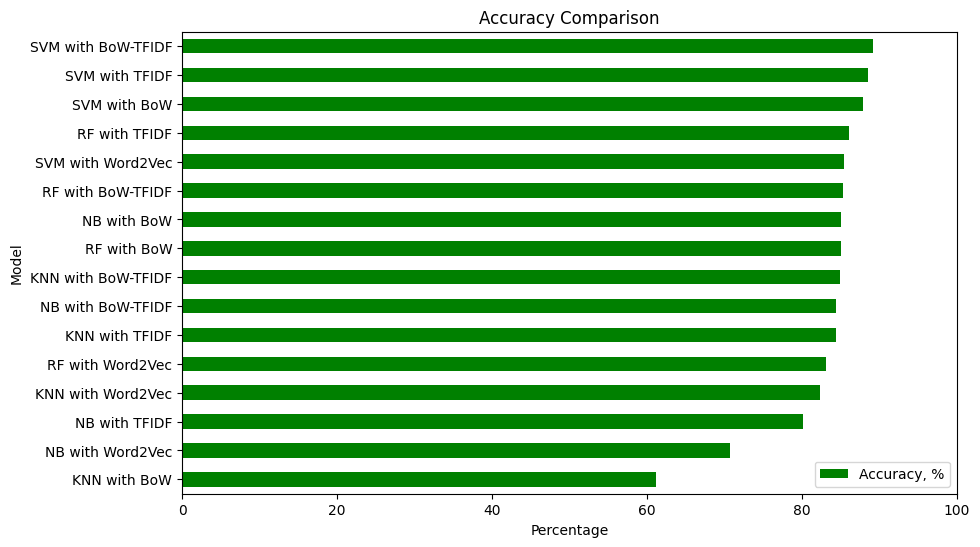

In [69]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Accuracy, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x='Model',y='Accuracy, %', figsize=(10, 6), color='green')
plt.title('Accuracy Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

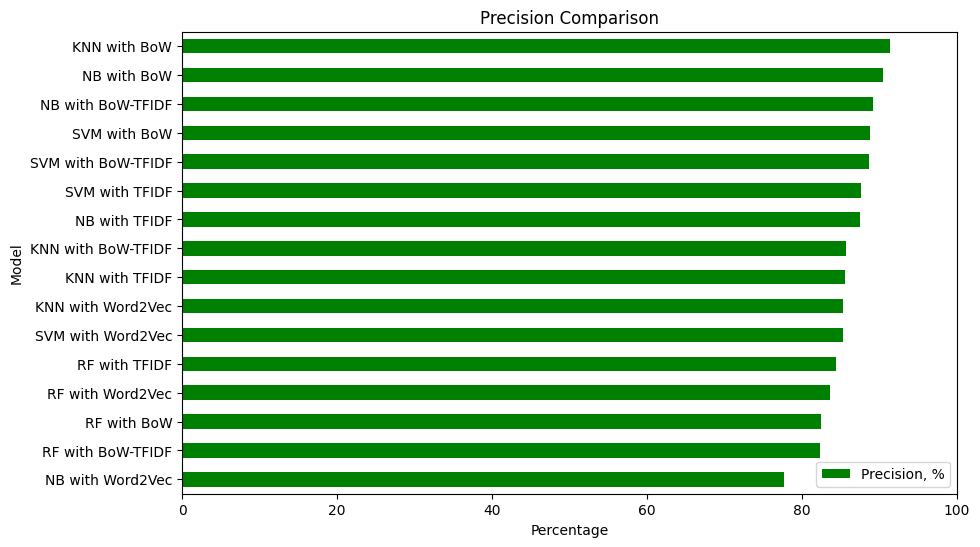

In [70]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Precision, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x='Model', y='Precision, %', figsize=(10, 6), color='green')
plt.title('Precision Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

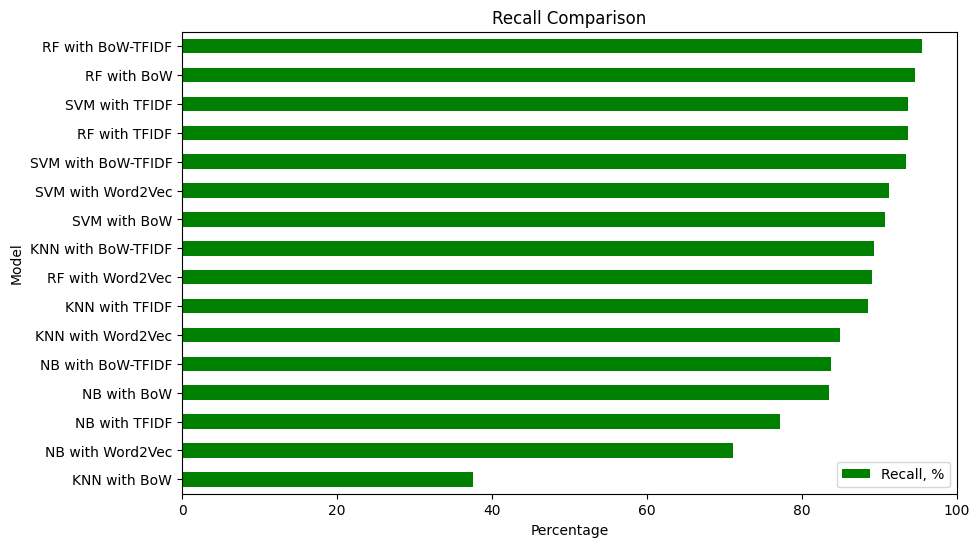

In [71]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Recall, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x='Model', y='Recall, %', figsize=(10, 6), color='green')
plt.title('Recall Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

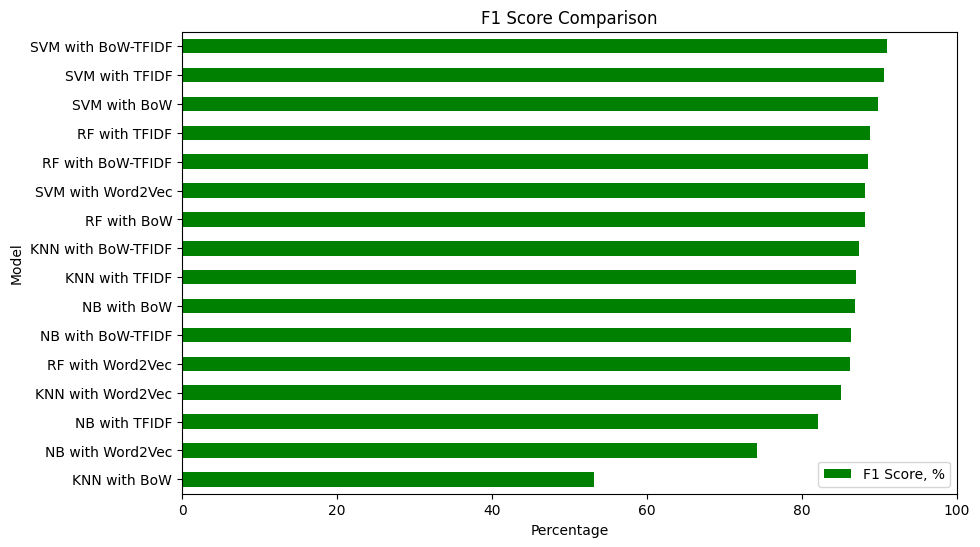

In [72]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='F1 Score, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x='Model', y='F1 Score, %', figsize=(10, 6), color='green')
plt.title('F1 Score Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

# Deployment (Streamlit)

Reference: https://www.youtube.com/watch?v=WLwjvWq0GWA&t=2307s

In [73]:
# Save the count_vectorizer as file

joblib.dump(count_vectorizer, 'C:/Users/User/Downloads/count_vectorizer.joblib')

['C:/Users/User/Downloads/count_vectorizer.joblib']

In [77]:
svm_model = SVC(C=10, gamma=0.1, kernel='rbf')

svm_model.fit(X_train_bowtfidf, y_train_bowtfidf)

print("accuracy:",svm_model.score(X_test_bowtfidf,y_test_bowtfidf))

accuracy: 0.8913551401869159


In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba.posseg as pseg
from sklearn.svm import SVC

def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([word for word, flag in words if flag != 'x'])

input_data = "山西省大同市有复印店出售变造的核酸检查报告。"
input_data = [jieba_tokenizer(input_data)]


# Load the saved vectorizer
saved_vectorizer = joblib.load('C:/Users/User/OneDrive - Universiti Malaya/P2 Machine Learning/Model/count_vectorizer.joblib')

# Transform the new input using the loaded vectorizer
new_input_transformed = saved_vectorizer.transform(input_data)


# Assuming svm_model is defined elsewhere
prediction = svm_model.predict(new_input_transformed)
print(prediction)

if prediction == 0:
    print("This is fake new.")
else:
    print("This is true new.")

[0]
This is fake new.


In [79]:
print(input_data)
print(new_input_transformed.shape)
print(saved_vectorizer)

['山西省 大同市 有 复印 店 出售 变造 的 核酸 检查报告']
(1, 113386)
CountVectorizer(ngram_range=(1, 2))


## Saving the trained Model

In [80]:
import pickle

In [81]:
filename = 'C:/Users/User/Downloads/trained_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [82]:
# loading the saved model
loaded_model = pickle.load(open('C:/Users/User/Downloads/trained_model.sav', 'rb'))

In [83]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba.posseg as pseg
from sklearn.svm import SVC

def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([word for word, flag in words if flag != 'x'])

input_data = "山西省大同市有复印店出售变造的核酸检查报告。"
input_data = [jieba_tokenizer(input_data)]


# Load the saved vectorizer
saved_vectorizer = joblib.load('C:/Users/User/OneDrive - Universiti Malaya/P2 Machine Learning/Model/count_vectorizer.joblib')

# Transform the new input using the loaded vectorizer
new_input_transformed = saved_vectorizer.transform(input_data)


# Assuming svm_model is defined elsewhere
prediction = loaded_model.predict(new_input_transformed)
print(prediction)

if prediction == 0:
    print("This is fake new.")
else:
    print("This is true new.")

[0]
This is fake new.


# 0 is fake new
# 1 is true new

streamlit run "C:\Users\User\Downloads\Fake new prediction web app.py"